In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
torch.manual_seed(0)

#import
data = pd.read_csv("amazon_reviews.txt", sep="\t", header=None)
#partition the clumns and make it lowercase for text
reviews = data.iloc[:,0].str.lower()
sentiment = data.iloc[:,1].values
    

0      so there is no way for me to plug it in here i...
1                            good case, excellent value.
2                                 great for the jawbone.
3      tied to charger for conversations lasting more...
4                                      the mic is great.
                             ...                        
995    the screen does get smudged easily because it ...
996    what a piece of junk.. i lose more calls on th...
997                         item does not match picture.
998    the only thing that disappoint me is the infra...
999    you can not answer calls with the unit, never ...
Name: 0, Length: 1000, dtype: object

In [16]:
#remove all punctuations
for i in punctuation:
    reviews = reviews.str.replace(i,"")
reviews

<ipython-input-16-cb09248c99de>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  reviews = reviews.str.replace(i,"")


0      so there is no way for me to plug it in here i...
1                              good case excellent value
2                                  great for the jawbone
3      tied to charger for conversations lasting more...
4                                       the mic is great
                             ...                        
995    the screen does get smudged easily because it ...
996    what a piece of junk i lose more calls on this...
997                          item does not match picture
998    the only thing that disappoint me is the infra...
999    you can not answer calls with the unit never w...
Name: 0, Length: 1000, dtype: object

In [36]:
#make every review into one 
words = ' '.join(reviews)
#splitting every word
words = words.split()
#bunching together
vocabuary = set(words)
indexer = {word : index for (index,word) in enumerate(vocabuary)}
#Putting the numeric representation of words into a list
indexed_review = []
for review in reviews:
    indexed_review.append([indexer[word] for word in review.split()])


In [44]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        out = out[-1,0]
        out = torch.sigmoid(out).unsqueeze(0)
        return out
    
model = LSTM(len(vocabuary), 64, 128, 3)
model

loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

losses = []
acc = []
for e in range(1, epochs+1):
    single_loss = []
    preds = []
    targets = []
    for i, r in enumerate(indexed_review):
        if len(r) <= 1:
            continue
        x = torch.Tensor([r]).long()
        y = torch.Tensor([sentiment[i]])
        
        pred = model(x)
        loss = loss_function(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        final_pred = np.round(pred.detach().numpy())
        preds.append(final_pred)
        targets.append(y)
        single_loss.append(loss.item())
        
    losses.append(np.mean(single_loss))
    accuracy = accuracy_score(targets, preds)
    acc.append(accuracy)
    if e%1 == 0:
        print("Epoch", e, "--> Loss function: ", losses[-1], "--> Accuracy: ", acc[-1])

D:\Akademik\ProgramsAndIDEs\Anaconda\envs\deep_learningPytorch\lib\site-packages\numpy\core\_asarray.py:102: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
D:\Akademik\ProgramsAndIDEs\Anaconda\envs\deep_learningPytorch\lib\site-packages\sklearn\utils\multiclass.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converte

ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [48]:
losses = []
acc = []
for e in range(1, epochs+1):
    single_loss = []
    preds = []
    targets = []
    for i, r in enumerate(indexed_review):
        if len(r) <= 1:
            continue
        x = torch.Tensor([r]).long()
        y = torch.Tensor([sentiment[i]])
    
        pred = model(x)
        loss = loss_function(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        final_pred = np.round(pred.detach().numpy())
        preds.append(final_pred)
        targets.append(y)
        single_loss.append(loss.item())
        
    losses.append(np.mean(single_loss))

    if e%1 == 0:
        print("Epoch: ", e, "... Loss function: ", losses[-1])

Epoch:  1 ... Loss function:  0.2110152020626486
Epoch:  2 ... Loss function:  0.14169229699230343
Epoch:  3 ... Loss function:  0.06068103324362616
Epoch:  4 ... Loss function:  0.06633802757326629
Epoch:  5 ... Loss function:  0.017547511260432892
Epoch:  6 ... Loss function:  0.04700783118340049
Epoch:  7 ... Loss function:  0.012185756198458596
Epoch:  8 ... Loss function:  0.0007121129681844224
Epoch:  9 ... Loss function:  0.0001753195352974352
Epoch:  10 ... Loss function:  8.997756470745012e-05


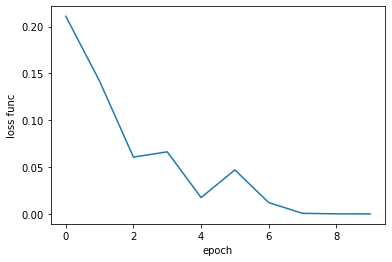

In [50]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epoch")
plt.ylabel("loss func")
plt.show()